# 02 - Data from the Web

In [2]:
# Needed imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import difflib
import seaborn as sns
import numpy as np
%matplotlib inline

## Some helper functions we need

This functions will be used throughout the homework.

In [3]:
# parses a string to an integer, removing invalid digits
def parseInt(numStr):
    cleaned = [x for x in numStr if x.isdigit()]
    return int("".join(cleaned))

# parses a string to a float, removing invalid digits
def parseDecimal(numStr):
    cleaned = [x for x in numStr if x.isdigit() or x == '.']
    return float("".join(cleaned))

## Task 1


### Remaks @todo

- Some values of student and faculty may be missing. They are set to 0.
- There is no university with rank #198. Therefore the interval of the rank is [1,201]
- Not every field was available in the main webpage, the missing information was retrieved from the description page of each university.


### a. Load data
- Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)) 

In [3]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt')
qs_dataset = r.json()['data']

In [ ]:
qs_dataset[0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

- For each university, we extract: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). The detailed information (faculty and students) is gathered from the respective page of each university. 

In [ ]:
results = []
for university in qs_dataset[:200]:
    url = 'https://www.topuniversities.com' + university['url']
    details_html = requests.get(url)
    soup = BeautifulSoup(details_html.text, 'html.parser')

    def parseAttribute(className):
        attr = soup.find('div', class_=className)
        if attr is not None:
            return parseInt(attr.find('div', class_='number').text)
        else:
            return 0 # Missing value
        
    results.append({
            'name': university['title'],
            'rank': parseInt(university['rank_display']),
            'country': university['country'],
            'region': university['region'],
            'faculty_international': parseAttribute('inter faculty'),
            'faculty_total': parseAttribute('total faculty'),
            'students_international': parseAttribute('total inter'),
            'students_total': parseAttribute('total student')
        })

- Convert the resulting dataset into a DataFrame and store it as a file (for reusing it later without parsing the content again).

In [ ]:
qs_df = pd.DataFrame.from_dict(results).set_index('name')
qs_df.to_pickle('qs_dataset')

In [5]:
qs_df = pd.read_pickle('qs_dataset')
qs_df.head()

,country,faculty_international,faculty_total,rank,region,students_international,students_total
name,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679,2982,1,North America,3717,11067
Stanford University,United States,2042,4285,2,North America,3611,15878
Harvard University,United States,1311,4350,3,North America,5266,22429
California Institute of Technology (Caltech),United States,350,953,4,North America,647,2255
University of Cambridge,United Kingdom,2278,5490,5,Europe,6699,18770


### b. Add the columns 'faculty_students_ratio' and 'international_ratio'

**'faculty_students_ratio'** represents the faculty-to-students ratio.

**'international_ratio'** represents the fraction of international students. 

In [6]:
qs_df['faculty_students_ratio'] = qs_df['faculty_total']/qs_df['students_total']
qs_df['international_ratio'] = qs_df['students_international']/qs_df['students_total']
# for this analysis, keep only the columns we are interested in 
qs_df_analysis = qs_df.loc[:, ['region', 'country','rank', 'faculty_students_ratio', 'international_ratio']]
qs_df_analysis.head()

,region,country,rank,faculty_students_ratio,international_ratio
name,,,,,
Massachusetts Institute of Technology (MIT),North America,United States,1,0.269450,0.335863
Stanford University,North America,United States,2,0.269870,0.227422
Harvard University,North America,United States,3,0.193945,0.234785
California Institute of Technology (Caltech),North America,United States,4,0.422616,0.286918
University of Cambridge,Europe,United Kingdom,5,0.292488,0.356899


- By sorting along these columns we can respectively find the best universities in terms of (a) ratio between faculty members and students and (b) ratio of international students.

In [7]:
sorted_ = qs_df_analysis.sort_values('faculty_students_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,country,rank,faculty_students_ratio,international_ratio
1,California Institute of Technology (Caltech),North America,United States,4,0.422616,0.286918
2,Yale University,North America,United States,16,0.398323,0.199081
3,University of Oxford,Europe,United Kingdom,6,0.342292,0.372870
4,University of Cambridge,Europe,United Kingdom,5,0.292488,0.356899
5,Johns Hopkins University,North America,United States,17,0.276353,0.254243


In [8]:
sorted_ = qs_df_analysis.sort_values('international_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,country,rank,faculty_students_ratio,international_ratio
1,London School of Economics and Political Scien...,Europe,United Kingdom,35,0.111475,0.691393
2,Ecole Polytechnique Fédérale de Lausanne (EPFL),Europe,Switzerland,12,0.163879,0.570047
3,Imperial College London,Europe,United Kingdom,8,0.244251,0.543567
4,Maastricht University,Europe,Netherlands,200,0.077937,0.502533
5,Carnegie Mellon University,North America,United States,47,0.100479,0.478062


- We answer the same question aggregating the data by (c) **country** and (d) **region**. For clarity reasons, here we show only the best value within each group, along with the university associated with that value.

In [59]:
# We define a helper function for aggregating the data and drawing the graph.
# This function will be used for the analysis of both QS and THE datasets.
# In our case, 'grouping_col' will be either 'country' or 'region,
# and 'value_col' will be either 'faculty_students_ratio' or 'international_ratio'.
def aggregate_analyze(df, grouping_col, value_col, title=""):
    '''
    Arguments:
    -- df: the DataFrame to process
    -- grouping_col: the column by which the data will be grouped
    -- value_col: the variabile to average within each group
    '''
    
    grouped = df.groupby([grouping_col]).mean()\
        .loc[:, [value_col]]\
        .sort_values(value_col, ascending=False)
    
    grouped_with_rank = grouped.reset_index()
    grouped_with_rank.index = range(1, len(grouped) + 1) # start index from 1
    
    # plot
    ax = grouped.plot.bar(title = title)
    ax.legend_.remove()
    ax.set_ylabel(value_col)
    
    return grouped_with_rank

#     # We group by 'grouping_col' and compute, for each group, the index corresponding to the entry with higher 
#     # 'value_col'. These indices are stored in maxIdx.
#     maxIdx = df.groupby([grouping_col], agg=p)[value_col].idxmax()

#     # We use those indices to access the original table and retrieve the needed list of universities. 
#     # Moreover, we keep the columns we are interested in, i.e. [grouping_col, 'name', value_col].
#     res = df.loc[maxIdx][[grouping_col, 'name', value_col]].set_index(grouping_col)
#     res = res.sort_values(value_col, ascending=False)
    
#     # We finally plot the data in a bar chart
#     display(res)
    
    

,country,faculty_students_ratio
1,Russia,0.221910
2,Denmark,0.186580
3,Saudi Arabia,0.175828
4,Singapore,0.162279
5,Japan,0.155840
6,Malaysia,0.153893
7,United States,0.151151
8,South Korea,0.149356
9,France,0.144006
10,Israel,0.136047


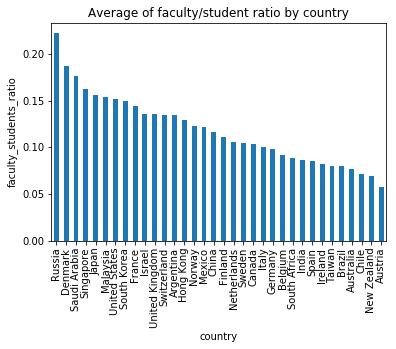

In [62]:
aggregate_analyze(qs_df_analysis, 'country', 'faculty_students_ratio', title="Average of faculty/student ratio by country").head(20)

,country,international_ratio
1,United Kingdom,0.351308
2,Australia,0.346878
3,Switzerland,0.313816
4,Hong Kong,0.312148
5,Austria,0.306095
6,Singapore,0.277091
7,Canada,0.252604
8,New Zealand,0.248971
9,Netherlands,0.245456
10,Ireland,0.241791


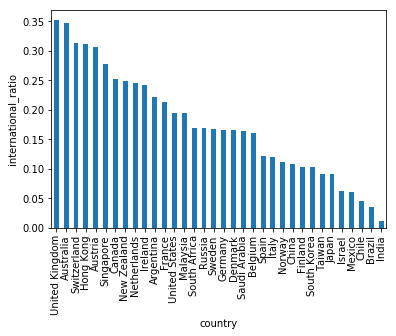

In [11]:
aggregate_analyze(qs_df_analysis, 'country', 'international_ratio', title="Average of intenational ratio by country")

,region,faculty_students_ratio
1,North America,0.144831
2,Asia,0.134673
3,Europe,0.120003
4,Latin America,0.096779
5,Africa,0.088450
6,Oceania,0.075003


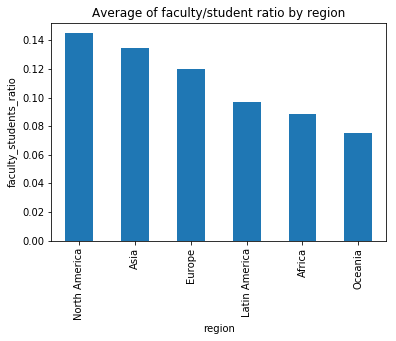

In [63]:
aggregate_analyze(qs_df_analysis, 'region', 'faculty_students_ratio', title="Average of faculty/student ratio by region")

,region,international_ratio
1,Oceania,0.329077
2,Europe,0.245932
3,North America,0.202437
4,Africa,0.169703
5,Asia,0.132394
6,Latin America,0.071751


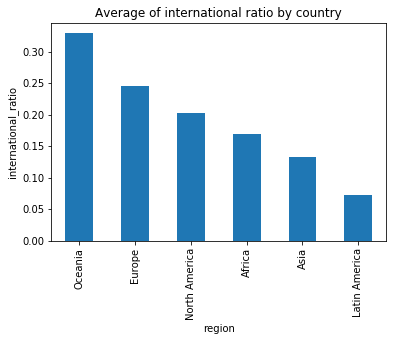

In [64]:
aggregate_analyze(qs_df_analysis, 'region', 'international_ratio', title="Average of international ratio by country")

## Task 2
We now obtain the 200 top-ranking universities from www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)) and repeat the previous analysis.

In [14]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
the_dataset = r.json()['data']

In [15]:
the_dataset[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

In [16]:
results = []
for university in the_dataset[:200]:
    results.append({
            'name': university['name'],
            'rank': parseInt(university['rank']),
            'country': university['location'],
            'faculty_students_ratio': 1 / parseDecimal(university['stats_student_staff_ratio']),
            'international_ratio': parseDecimal(university['stats_pc_intl_students']) / 100,
            'students_total': parseInt(university['stats_number_students'])
        })

the_df = pd.DataFrame.from_dict(results).set_index('name')

# Compute derived attributes (where applicable)
the_df['students_international'] = (the_df['students_total'] * the_df['international_ratio']).astype('int')
the_df['faculty_total'] = (the_df['students_total'] * the_df['faculty_students_ratio']).astype('int')

In [17]:
# Map countries to regions using the QS dataset
mapping = qs_df[['country', 'region']].set_index('country').to_dict()['region']

# Manually add missing mappings
mapping['Luxembourg'] = 'Europe'
mapping['Russian Federation'] = 'Europe'

the_df['region'] = the_df['country'].replace(mapping)

# for this analysis keep only the columns we are interested in
the_df_analysis = the_df.loc[:, ['region', 'rank', 'country', 'faculty_students_ratio', 'international_ratio']]
the_df_analysis.head()

,region,rank,country,faculty_students_ratio,international_ratio
name,,,,,
University of Oxford,Europe,1,United Kingdom,0.089286,0.38
University of Cambridge,Europe,2,United Kingdom,0.091743,0.35
California Institute of Technology,North America,3,United States,0.153846,0.27
Stanford University,North America,3,United States,0.133333,0.22
Massachusetts Institute of Technology,North America,5,United States,0.114943,0.34


In [18]:
sorted_ = the_df_analysis.sort_values('faculty_students_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,rank,country,faculty_students_ratio,international_ratio
1,Vanderbilt University,North America,105,United States,0.303030,0.13
2,University of Copenhagen,Europe,109,Denmark,0.243902,0.14
3,University of Rochester,North America,153,United States,0.232558,0.29
4,Yale University,North America,12,United States,0.232558,0.21
5,Johns Hopkins University,North America,13,United States,0.232558,0.24


In [19]:
sorted_ = the_df_analysis.sort_values('international_ratio', ascending=False).reset_index()
sorted_.index = range(1, len(sorted_) + 1) # start index from 1
sorted_.head()

,name,region,rank,country,faculty_students_ratio,international_ratio
1,London School of Economics and Political Science,Europe,25,United Kingdom,0.081967,0.71
2,University of Luxembourg,Europe,179,Luxembourg,0.068493,0.57
3,École Polytechnique Fédérale de Lausanne,Europe,38,Switzerland,0.089286,0.55
4,Imperial College London,Europe,8,United Kingdom,0.087719,0.55
5,Maastricht University,Europe,103,Netherlands,0.055556,0.50


,country,faculty_students_ratio
1,Denmark,0.160166
2,Italy,0.138889
3,Russian Federation,0.136986
4,Japan,0.132098
5,United States,0.106390
6,France,0.099352
7,China,0.087420
8,Taiwan,0.086957
9,South Africa,0.085470
10,Switzerland,0.083447


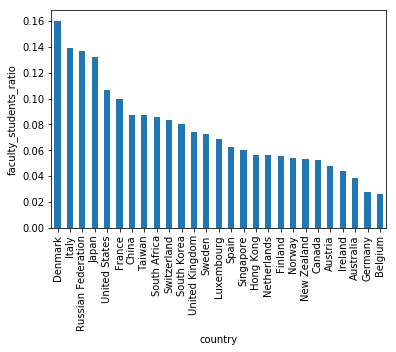

In [20]:
aggregate_analyze(the_df_analysis, 'country', 'faculty_students_ratio')

,country,international_ratio
1,Luxembourg,0.570000
2,United Kingdom,0.365484
3,Hong Kong,0.328000
4,Switzerland,0.314286
5,Australia,0.307500
6,Singapore,0.305000
7,New Zealand,0.290000
8,Ireland,0.270000
9,Austria,0.260000
10,Canada,0.225000


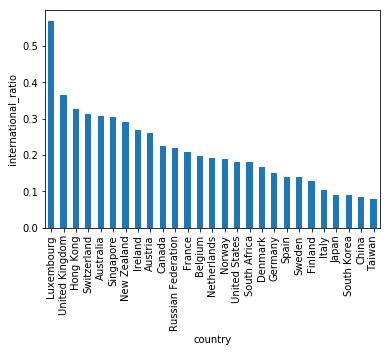

In [21]:
aggregate_analyze(the_df_analysis, 'country', 'international_ratio')

,region,faculty_students_ratio
1,North America,0.101655
2,Africa,0.085470
3,Asia,0.080345
4,Europe,0.065952
5,Oceania,0.039895


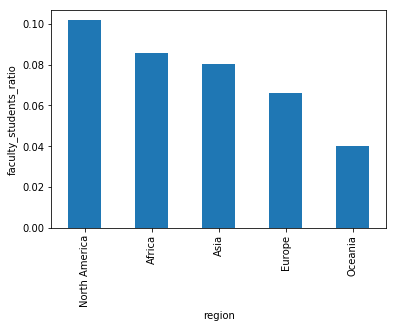

In [22]:
aggregate_analyze(the_df_analysis, 'region', 'faculty_students_ratio')

,region,international_ratio
1,Oceania,0.305556
2,Europe,0.244653
3,North America,0.185588
4,Africa,0.180000
5,Asia,0.165238


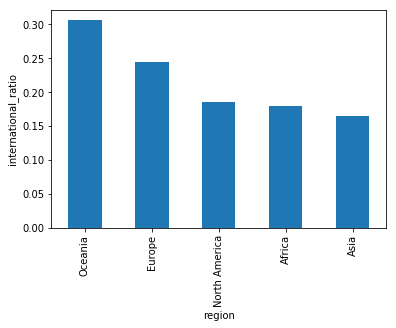

In [23]:
aggregate_analyze(the_df_analysis, 'region', 'international_ratio')

In [57]:
not_matched_counter = 0

qs_df_ = qs_df.copy().reset_index()
the_df_ = the_df.copy().reset_index()
def mapName(name):
    global not_matched_counter
    tolerance = 0.6
    res = difflib.get_close_matches(name, the_df_['name'], 1, tolerance)
    if len(res) > 0:
        back_res = difflib.get_close_matches(res[0], qs_df_['name'], 1, tolerance)
        if len(back_res) > 0 and name == back_res[0]:
            return res[0]
    not_matched_counter += 1
    return name

qs_df_['name'] = qs_df_['name'].map(mapName)
print(not_matched_counter, 'universities were not matched.')
merged_df = qs_df_.merge(the_df_, on='name', how='inner', suffixes=('_qs', '_the'))

# clean the table (only one column for the region and the country)
merged_df["region"] = merged_df.region_qs
merged_df["country"] = merged_df.country_qs
merged_df.drop(['region_qs', 'region_the', 'country_qs', 'country_the'], axis = 1, inplace = True)

merged_df

49 universities were not matched.


,name,faculty_international,faculty_total_qs,rank_qs,students_international_qs,students_total_qs,faculty_students_ratio_qs,international_ratio_qs,faculty_students_ratio_the,international_ratio_the,rank_the,students_total_the,students_international_the,faculty_total_the,region,country
0,Massachusetts Institute of Technology,1679,2982,1,3717,11067,0.269450,0.335863,0.114943,0.34,5,11177,3800,1284,North America,United States
1,Stanford University,2042,4285,2,3611,15878,0.269870,0.227422,0.133333,0.22,3,15845,3485,2112,North America,United States
2,Harvard University,1311,4350,3,5266,22429,0.193945,0.234785,0.112360,0.26,6,20326,5284,2283,North America,United States
3,California Institute of Technology,350,953,4,647,2255,0.422616,0.286918,0.153846,0.27,3,2209,596,339,North America,United States
4,University of Cambridge,2278,5490,5,6699,18770,0.292488,0.356899,0.091743,0.35,2,18389,6436,1687,Europe,United Kingdom
5,University of Oxford,2964,6750,6,7353,19720,0.342292,0.372870,0.089286,0.38,1,20409,7755,1822,Europe,United Kingdom
6,University College London,2554,6345,7,14854,31080,0.204151,0.477928,0.095238,0.49,16,30304,14848,2886,Europe,United Kingdom
7,Imperial College London,2071,3930,8,8746,16090,0.244251,0.543567,0.087719,0.55,8,15857,8721,1390,Europe,United Kingdom
8,University of Chicago,635,2449,9,3379,13557,0.180645,0.249244,0.161290,0.25,9,13525,3381,2181,North America,United States
9,ETH Zurich – Swiss Federal Institute of Techno...,1886,2477,10,7563,19815,0.125006,0.381681,0.068493,0.38,10,19233,7308,1317,Europe,Switzerland


In [56]:
# d = {'faculty_total' : merged_df[["faculty_total_qs", "faculty_total_the"]]}
# pd.concat(d.values(), axis=1, keys=d.keys())
cleaned = merged_df.copy()[['name',"faculty_total_qs", "faculty_total_the", 'rank_qs', 'rank_the']]

col_level1 = ['','faculty_total', 'rank']
col_level2 = ['name','faculty_total_qs', 'faculty_total_the', 'rank_qs', 'rank_the']

cleaned.columns \
    = pd.MultiIndex(levels=[col_level1, col_level2], labels=[[0, 1, 1, 2, 2], range(len(col_level2))])
cleaned

faculty_total  \
                                                  name faculty_total_qs   
0                Massachusetts Institute of Technology           2982.0   
1                                  Stanford University           4285.0   
2                                   Harvard University           4350.0   
3                   California Institute of Technology            953.0   
4                              University of Cambridge           5490.0   
5                                 University of Oxford           6750.0   
6                            University College London           6345.0   
7                              Imperial College London           3930.0   
8                                University of Chicago           2449.0   
9    ETH Zurich – Swiss Federal Institute of Techno...           2477.0   
10         Nanyang Technological University, Singapore           4338.0   
11            École Polytechnique Fédérale de Lausanne           1695.0   
12                                Princeton University           1007.0   
13                                  Cornell University           2718.0   
14                    National University of Singapore           5106.0   
15                                     Yale University           4940.0   
16                            Johns Hopkins University           4462.0   
17                                 Columbia University           6189.0   
18                          University of Pennsylvania           5499.0   
19                      Australian National University           1600.0   
20                                     Duke University           2938.0   
21                              University of Michigan           6809.0   
22                               King’s College London           3650.0   
23                             University of Edinburgh           4075.0   
24                                 Tsinghua University           5506.0   
25                             University of Hong Kong           3012.0   
26                  University of California, Berkeley           3321.0   
27                             Northwestern University           4231.0   
28                                 University of Tokyo           4514.0   
29      Hong Kong University of Science and Technology           1150.0   
..                                                 ...              ...   
219                              University of Cologne              NaN   
220                 Autonomous University of Barcelona              NaN   
221                               University of Sussex              NaN   
222                           University of Notre Dame              NaN   
223                         Scuola Superiore Sant’Anna              NaN   
224                                         TU Dresden              NaN   
225                                     Ulm University              NaN   
226                    Case Western Reserve University              NaN   
227                            University of Leicester              NaN   
228                              University of Arizona              NaN   
229               University of California, Santa Cruz              NaN   
230                   University of Erlangen-Nuremberg              NaN   
231                       Vrije Universiteit Amsterdam              NaN   
232                             University of Würzburg              NaN   
233                University of Alabama at Birmingham              NaN   
234        Rutgers, the State University of New Jersey              NaN   
235                              University of Münster              NaN   
236                      Université Libre de Bruxelles              NaN   
237                           University of Luxembourg              NaN   
238                               Paris-Sud University              NaN   
239                                University of Miami              NaN   
240     

In [26]:
cols_qs = merged_df[['rank_qs', 'faculty_total_qs', 'students_international_qs',
                  'students_total_qs', 'faculty_students_ratio_qs', 'international_ratio_qs']]
cols_the = merged_df[['rank_the', 'faculty_total_the', 'students_international_the',
                  'students_total_the', 'faculty_students_ratio_the', 'international_ratio_the']]
cols_qs.columns = cols_qs.columns.map(lambda x: x.rstrip('_qs'))
cols_the.columns = cols_the.columns.map(lambda x: x.rstrip('_the'))
cols_qs.corrwith(cols_the)

rank                      0.689643
faculty_total             0.697652
students_international    0.890919
students_total            0.944379
faculty_students_ratio    0.712781
international_ratio       0.952672
dtype: float64

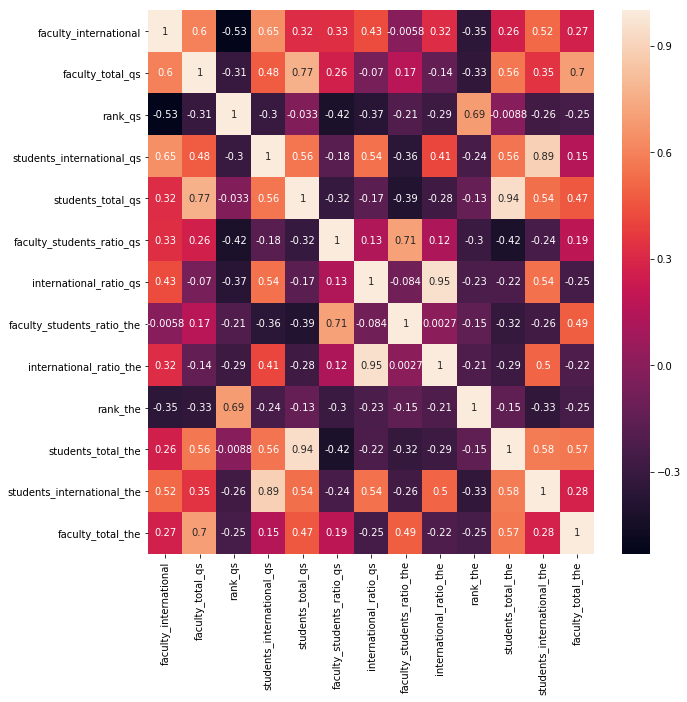

In [27]:
corr = merged_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [28]:
corr_pairs = abs(corr).unstack().reset_index()
corr_pairs.columns = [['var1', 'var2', 'corr']]
corr_pairs = corr_pairs[corr_pairs['var1'] > corr_pairs['var2']] # Remove redundant entries
corr_pairs[corr_pairs['corr'] > 0.5].sort_values('corr', ascending=False)

,var1,var2,corr
110,international_ratio_the,international_ratio_qs,0.952672
134,students_total_the,students_total_qs,0.944379
146,students_international_the,students_international_qs,0.890919
53,students_total_qs,faculty_total_qs,0.767160
96,faculty_students_ratio_the,faculty_students_ratio_qs,0.712781
157,faculty_total_the,faculty_total_qs,0.697652
119,rank_the,rank_qs,0.689643
39,students_international_qs,faculty_international,0.646589
13,faculty_total_qs,faculty_international,0.596562
141,students_total_the,students_international_the,0.578362


In [29]:
rankings = merged_df[['name', 'rank_qs', 'rank_the']].copy()
rankings['rank_avg'] = (rankings['rank_qs'] + rankings['rank_the'])/2
rankings.sort_values('rank_avg', ascending=True).head(10)

,name,rank_qs,rank_the,rank_avg
1,Stanford University,2.0,3.0,2.5
0,Massachusetts Institute of Technology,1.0,5.0,3.0
3,California Institute of Technology,4.0,3.0,3.5
4,University of Cambridge,5.0,2.0,3.5
5,University of Oxford,6.0,1.0,3.5
2,Harvard University,3.0,6.0,4.5
7,Imperial College London,8.0,8.0,8.0
8,University of Chicago,9.0,9.0,9.0
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10.0,10.0
12,Princeton University,13.0,7.0,10.0
